In [1]:
import tensorflow as tf
from gradient_accumulator.GAModelWrapper import GAModelWrapper


######### MODEL #########


base_model = tf.keras.applications.ResNet152V2(include_top=True, 
                                                   weights=None, 
                                                input_shape=(360, 256, 2), 
                                                classes=1,
                                                classifier_activation="sigmoid")
inputs = tf.keras.Input(shape=(360, 256, 2))
x = base_model(inputs, training=True)
model = tf.keras.Model(inputs, x)

model = GAModelWrapper(accum_steps=1, inputs=model.input, outputs=model.output)


model.load_weights("model.h5")



/home/viktor/.local/lib/python3.10/site-packages/keras/applications/resnet.py:135: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
2022-12-23 00:37:30.151899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 00:37:30.209702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 00:37:30.209906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 00:37:30.210286: I tensorflow/core/platform/cpu_feature_guard.cc:193] T

In [10]:
import pandas as pd
df = pd.read_csv("/media/viktor/T7/gravitational-waves-kaggle-2022/datasets/dataset-v1/data.csv")
df

,file,label,depth
0,/media/viktor/T7/gravitational-waves-kaggle-20...,1,14.395424
1,/media/viktor/T7/gravitational-waves-kaggle-20...,0,16.763065
2,/media/viktor/T7/gravitational-waves-kaggle-20...,1,23.607238
3,/media/viktor/T7/gravitational-waves-kaggle-20...,0,21.931825
4,/media/viktor/T7/gravitational-waves-kaggle-20...,0,9.933270
...,...,...,...
83995,/media/viktor/T7/gravitational-waves-kaggle-20...,1,11.677980
83996,/media/viktor/T7/gravitational-waves-kaggle-20...,1,22.839463
83997,/media/viktor/T7/gravitational-waves-kaggle-20...,1,19.598233
83998,/media/viktor/T7/gravitational-waves-kaggle-20...,1,13.881928


In [15]:
df["depth"].max()

23.984778859709685

In [11]:

df = df[df["depth"] > 20].reset_index(drop=True)
# take 256 samples
df = df.sample(128).reset_index(drop=True)
df

,file,label,depth
0,/media/viktor/T7/gravitational-waves-kaggle-20...,1,20.314411
1,/media/viktor/T7/gravitational-waves-kaggle-20...,1,22.189067
2,/media/viktor/T7/gravitational-waves-kaggle-20...,0,21.107977
3,/media/viktor/T7/gravitational-waves-kaggle-20...,1,22.088633
4,/media/viktor/T7/gravitational-waves-kaggle-20...,1,22.320415
...,...,...,...
123,/media/viktor/T7/gravitational-waves-kaggle-20...,0,20.807726
124,/media/viktor/T7/gravitational-waves-kaggle-20...,0,20.244274
125,/media/viktor/T7/gravitational-waves-kaggle-20...,1,20.982535
126,/media/viktor/T7/gravitational-waves-kaggle-20...,1,21.844139


In [12]:
# Loop over the dataset and make predictions: save the predictions to a list and create a column in the dataframe
# with the predictions
import numpy as np
from tqdm import tqdm
predictions = []
for i in tqdm(range(len(df))):
    # Get the path to the file
    path = df.iloc[i]["file"]
    # Load the data
    data = np.load(path)
    # Reshape the data
    data = data.reshape(1, 360, 256, 2)
    # Make a prediction
    prediction = model.predict(data, verbose=0)
    # Save the prediction
    predictions.append(prediction[0][0])
    
df["prediction"] = predictions
df

100%|██████████| 128/128 [00:31<00:00,  4.07it/s]


,file,label,depth,prediction
0,/media/viktor/T7/gravitational-waves-kaggle-20...,1,20.314411,0.388007
1,/media/viktor/T7/gravitational-waves-kaggle-20...,1,22.189067,0.311754
2,/media/viktor/T7/gravitational-waves-kaggle-20...,0,21.107977,0.427348
3,/media/viktor/T7/gravitational-waves-kaggle-20...,1,22.088633,0.316545
4,/media/viktor/T7/gravitational-waves-kaggle-20...,1,22.320415,0.669962
...,...,...,...,...
123,/media/viktor/T7/gravitational-waves-kaggle-20...,0,20.807726,0.324857
124,/media/viktor/T7/gravitational-waves-kaggle-20...,0,20.244274,0.295349
125,/media/viktor/T7/gravitational-waves-kaggle-20...,1,20.982535,0.334961
126,/media/viktor/T7/gravitational-waves-kaggle-20...,1,21.844139,0.893802


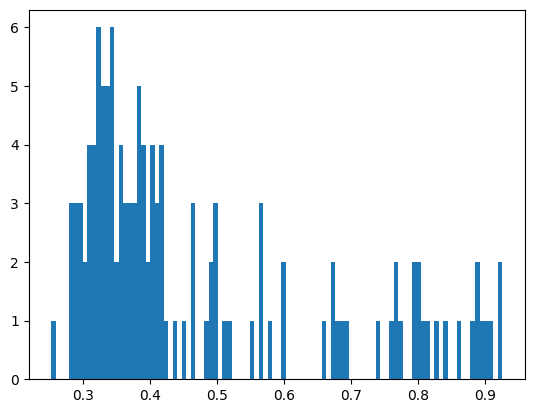

In [13]:
import matplotlib.pyplot as plt
plt.hist(df["prediction"], bins=100);

In [14]:
# calculate auc
from sklearn.metrics import roc_auc_score
roc_auc_score(df["label"], df["prediction"])

0.7650246305418719